# Rivi Assignment

**Author**: Eshwar Prasad. S

# TSP Using Genetic Algorithm

# Definitions 

1. TSP : Given a list of cities and the distances between each pair of cities, what is the shortest possible route that visits each city exactly once and returns to the origin city?

2. Genetic Algorithm :  Genetic Algorithm is a metaheuristic inspired by the process of natural selection.

3. Gene : One position in the chromosome

4. Allele : One of the possible values a gene can take for a particular chromosome

5. Chromosome : A particular combination of genes, a single solution to the problem statement. a.k.a 'Individual'.

6. Population : A particular collection of chromosomes, or, "Individuals". 

7. Fitness : The function to be optimized (usually to be maximized or minimized, also denoted as Y = f(x) ).

# Contextual Definitions : 

1. Gene : Gene for the given problem (TSP) would be a single element in the list of cities in a particular route. 

2. Allele : The alleles for a TSP problem are the possible cities (in the form of Coordinates). 

3. Chromosome : Chromosome for a TSP problem is a list of cities, in other words, a particular 'route' that satisfies the condition of : visit all cities once and only once. 

4. Population : A particular collection of routes.

5. Fitness : The fitness function for the TSP Problem is total distance (minimize distance). 


Further Definitions / Notes are added throughout the notebook to make things clear

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import random 
import pandas as pd
import matplotlib.pyplot as plt
import time
from itertools import islice

# Class Definitions

1. **Class Route**: This class represents one route (a single combination of the cities involved). The route has an associated 'path', an associated total 'distance' and the 'fitness' which is just the inverse of distance. 

2. **Class Node**: This class represents a single node in the graph, or in other words, a single city. Naturally the node class has x and y coordinates, and a function which returns a tuple of (x,y).

In [3]:
#Defining a class for a Route. Thinking semantically, a route has the sequential path, has the total distance and an associated 'fitness' score. 
#Fitness here can be taken as 1/distance to convert it to a maximization problem.
class Route: 
  def __init__(self, path):
    self.path = path
    self.distance = 0
    self.fitness = float(0)

#function to calculate distance between two given cities present within the given route
  
  def cityDistance(self, fromIndex, toIndex):
    distance = np.sqrt((abs(self.path[fromIndex].x - self.path[toIndex].x)**2) + (abs(self.path[fromIndex].y - self.path[toIndex].y)**2))
    return distance 

#function to claculate a given route object's total distance
  def totalDistance(self):
    if not self.distance:
      routeDistance = 0
      for i in range(0, len(self.path)):
        fromIndex = i
        if (i + 1) < len(self.path):
          toIndex = i+1
        else:
          toIndex = 0
        
        routeDistance = routeDistance + self.cityDistance(fromIndex, toIndex)
      
      self.distance = routeDistance
    return self.distance

  def Fitness(self):
    if not self.fitness:
      self.fitness = 1 / float(self.totalDistance())
    return self.fitness


In [4]:
#Defining a class for a single city
class Node:
  def __init__(self, x, y):
    self.x = x
    self.y = y
  def getCoords(self):
    return ((self.x, self.y))

In [5]:
mycity = Node(123,456)
mycity.getCoords()

(123, 456)

In [6]:
#Testing Distance Methods
city1 = Node(123,346)
city2 = Node(456,123)

cityList = []

cityList.append(city1)
cityList.append(city2)


dummypath = cityList

myroute = Route(dummypath)
mydistance = myroute.totalDistance()
mydistance

# distance2 = myroute.cityDistance(0,1)
# distance2


801.5435109836521

# Initial Population

1. **createInitPop(cities, size)** : args = list of cities, size of the population. Randomly samples cities from the given city list to create a route, and returns a list of these randomly created routes, with a length = size.

2. **orderPopulation(population)** : args = a single population. Orders the given population in descending order of fitness, returns a list of tuples (index, fitness).
 

In [7]:
#A function to randomize and create an Initial Population for GA. Input = list of cities and the size of the desired initial population.
def createInitPop(cities, size):
  population = []

  for i in range(0, size):
    route = random.sample(cities, len(cities))
    population.append(route)
  
  return population


In [8]:
#Function to reorder the population in descending order of the fitness value.
def orderPopulation(population):

    fitnessDict = {}

    for i in range(0, len(population)):
      fitnessDict[i] = Route(population[i]).Fitness()
    
    orderedRoutes = sorted(fitnessDict.items(), key=lambda kv: kv[1], reverse = True)

    return orderedRoutes


# Fitness Proportionate Selection

In fitness proportionate selection (a.k.a Roulette Wheel Selection), the probability of an individual from a population being selected for crossover is directly proportional to its fitness. To imagine this, the size of the portion of the wheel an individual gets is proportional to its fitness. There are other selection methods such as tournament selection, but for this implementation, Roulette Wheel has been chosen.

**Implementation**:

The method to implement this is to calculate the cumulative fitness of each individual from the least fit to most fit one, and use that to calculate the cumulative probability of each individual. To ***simulate the roulette wheel's spinning***, a random probability is picked (between 0,1) and the interval bucket in which this probability falls is picked and that individual is selected for selection.

In [9]:
#Fitness Proportionate Selection, a.k.a Roulette Wheel Selection. 
def selection(orderedPop, numElite, population):

    candidatesIndex = []
    
    #Applying elitism here, retaining the top numElite chromosomes for next generation
    for i in range(0, numElite):
      candidatesIndex.append(orderedPop[i][0])

    populationdf = pd.DataFrame(np.array(orderedPop), columns = ["route_index", "route_fitness"])
    populationdf['cumulative_fitness'] = populationdf.route_fitness.cumsum()
    total_fitness = float(populationdf.route_fitness.sum())
    populationdf['cumulative_probability'] = populationdf.cumulative_fitness / total_fitness

    #Fitness Proportionate Selection. Compute cumulative probabilities -> select a random number in total range -> check where the random number falls, add that as a potential candidate 
    for i in range(0, (len(orderedPop)-numElite)):
      randnum = random.random()

      for i in range(0, len(orderedPop)):
        if randnum <= populationdf.iloc[i]['cumulative_probability']:
          candidatesIndex.append(orderedPop[i][0])
          break
    
    candidates = []
    for i in range(0, len(candidatesIndex)):
      index = candidatesIndex[i]
      candidates.append(population[index])
    

    return candidates


# Ordered Crossover (OX)

**Ordered Crossover**: Is a type of crossover used for permutation problems in genetic algorithms. The task at hand, TSP, is a classic permutation problem (if I represent using path representation, which I have). There are other crossover methods such as Cycle Crossover (CX) and Partially Mapped Crossover (PMX), but for this implementation, I have chosen OX since it is a straightforward method to produce valid children.

In ordered crossover, a particular slice of a single parent1 is passed onto the child, and the rest of the elements that do not appear in the slice of parent1 are taken to the child in the same order as they appear in parent2. 

**For example** :

Parent 1 = 1 2 3 | 4 5 6 7 | 8 9

Parent 2 = 4 5 2 | 1 8 7 6 | 9 3

and the solution child is :

Child = 2 1 8 | 4 5 6 7 | 9 3

If so desired, a second child can be aquired in the same manner : 

Child2 = 3 4 5 | 1 8 7 6 | 9 2

In this implementation, I consider only one child, and I breed the mating pool with the reverse of the mating pool to get the same population length.





In [10]:
#Implementing a function to perform ordered crossover between two given parents, producing a single child. 
def ordered_crossover(parent1, parent2):

    child = []
    parent1slice = []
    parent2slice = []

    index1 = random.sample(range(len(parent1)), 1)[0]
    index2 = random.sample(range(len(parent1)), 1)[0]

    # index1 = 3
    # index2 = 6

    startIndex, endIndex = min(index1,index2), max(index1, index2)

    # print(startIndex, endIndex)
   
    parent1slice = parent1[startIndex : endIndex+1]


    childIndex = 0
    

    for i in range(len(parent2)):
      if(parent2[i] not in parent1slice and parent2[i] not in parent2slice):
        child.append(parent2[i])
        parent2slice.append(parent2[i])
        childIndex = childIndex + 1
      if childIndex >= startIndex : 
        break

    child.extend(parent1slice)

    childIndex = endIndex


    for j in range(len(parent2)):
      if(parent2[j] not in parent1slice and parent2[j] not in parent2slice):
        child.append(parent2[j])
        parent2slice.append(parent2[j])
        childIndex += 1
      if childIndex >= len(parent1):
        break

    return child
  


In [ ]:
print(ordered_crossover(parent1=[1,2,3,4,5,6,7,8,9],parent2=[4,5,2,1,8,7,6,9,3]))

[2, 1, 8, 4, 5, 6, 7, 9, 3]


# Elitism

In Genetic Algorithms, Elitism is the concept of retaining some of the best performing individuals (in terms of fitness) and passing them over to the next generation. The concept here is to 'guarantee' a spot for these 'elites' in the immediately next generation. This is usually done to make sure that the fittest gene combinations are preserved to a degree. 

In [11]:
#Function to create a new generation. Introduce elites into the new generation, create a mating pool of candidates and crossing them over using ordered cross over.
def generatePopulation(candidates, numElite):
    newpopulation = []
    length = len(candidates) - numElite
    matingpool = random.sample(candidates, len(candidates))

    for i in range(numElite):
        newpopulation.append(candidates[i])
    
    for i in range(0, length):
        child = ordered_crossover(matingpool[i], matingpool[len(matingpool)-i-1])
        newpopulation.append(child)
    return newpopulation

# Mutation Methods : 

Mutation operators are used in Genetic Algorithm to introduce and retain diversity in the individuals during reproduction / breeding. 

There are several mutation operators in the literature, but not all are applicable to Traveling Salesman Problem, as TSP has the restriction of 'valid routes'. That is, a route must have one and only entry of a particular city. 

In light of this, 3 different mutation methods have been implemented and are given as the choice while running the algorithm : 

1. **Swap Mutation** : In this method of mutation, each city in the route is checked for mutation against the mutation rate. If the city rolls a random number (0,1) less than the mutation rate, the city is randomly swapped with another from the same route. 

**example** : [1,2,3,4,5,6,7,8,9,10] -> [5,2,3,4,1,6,7,8,9,10]  where the 0th element has been chosen to be mutated, and the element at index 4 has been swapped with it. 

2. **Inversion Mutation** : In this method of mutation, a random section/slice of the route is chosen and the order of this slice is randomized; by doing this, the mutated individual is still a valid route. In this implementation, I have scaled up the mutation rate by a factor of 10^2, since the length of the slice is calculated as : mutationRate * length(route)

**example** : [1,2,3,4,5,6,7,8,9,10] -> [5,4,3,2,1,6,7,8,9,10] where the slice [1,2,3,4,5] has been inverted. 

3. **Scramble Mutation** : Similar to Inversion Mutation, a random selection/slice of the route is chosen and the order of elements in the slice is randomized. 

**example** : [1,2,3,4,5,6,7,8,9,10] -> [1,2,3,4,8,5,7,6,9,10] where the slice [5,6,7,8,9] has been randomized.



In [12]:
#Swap Mutation for one route
def swap_mutate(route, mutationRate):
    for index1 in range(len(route)):
        if(random.random() < mutationRate):

          index2 = np.random.choice(np.arange(len(route)))
          # index2 = random.choice(route).index()

          route[index1], route[index2] = route[index2], route[index1]
          # print(index1, index2)
 
    # print(route)

    return route


In [ ]:
swap_mutate([1,2,3,4,5,6,7,8,9,10], 0.1)

[1, 2, 3, 4, 5, 7, 6, 8, 9, 10]

In [13]:
def inversion_mutate(route, mutationRate):

  mutationRate = mutationRate * 100
  
  sliceLength = round(mutationRate*len(route))
  randomIndex = np.random.choice(np.arange(len(route)))
 

  if (randomIndex + sliceLength) < len(route):

    selectedSlice = route[randomIndex:(randomIndex+sliceLength)]
    selectedSlice.reverse()
    
    route[randomIndex:(randomIndex+sliceLength)] = selectedSlice

  else: 
    endSlice = route[randomIndex:len(route)]
    startSlice = route[:sliceLength-len(endSlice)]

    totalSlice = endSlice+startSlice
    totalSlice.reverse()

    route[randomIndex:len(route)] = totalSlice[:len(endSlice)]
    route[:len(startSlice)] = totalSlice[len(endSlice):]

  return route


In [ ]:
inversion_mutate([1,2,3,4,5,6,7,8,9,10], 0.005)

[1, 2, 3, 8, 7, 6, 5, 4, 9, 10]

In [14]:
def scramble_mutate(route, mutationRate):

  mutationRate = mutationRate * 100
  
  sliceLength = round(mutationRate*len(route))
  randomIndex = np.random.choice(np.arange(len(route)))
  


  if (randomIndex + sliceLength) < len(route):
    
    selectedSlice = route[randomIndex:(randomIndex+sliceLength)]
    np.random.shuffle(selectedSlice)
    
    route[randomIndex:(randomIndex+sliceLength)] = selectedSlice

  else: 
    endSlice = route[randomIndex:len(route)]
    startSlice = route[:sliceLength-len(endSlice)]

    totalSlice = endSlice+startSlice
    np.random.shuffle(totalSlice)

    route[randomIndex:len(route)] = totalSlice[:len(endSlice)]
    route[:len(startSlice)] = totalSlice[len(endSlice):]

  return route


In [ ]:
scramble_mutate([1,2,3,4,5,6,7,8,9,10], 0.005)

[1, 2, 3, 7, 6, 4, 8, 5, 9, 10]

In [15]:
#function to call a mutate function on each route. 
def mutatePopulation(population, mutationRate, mutation_type = "swap"):
    mutatedPopulation = []
    
    for i in range(len(population)):

      if mutation_type == "swap":
        route = swap_mutate(population[i], mutationRate)
        mutatedPopulation.append(route)

      elif mutation_type == "inversion":
        route = inversion_mutate(population[i], mutationRate)
        mutatedPopulation.append(route)
      
      elif mutation_type == "scramble":
        route = scramble_mutate(population[i], mutationRate)
        mutatedPopulation.append(route)

    return mutatedPopulation

In [ ]:
mutatePopulation([[1,2,3,4,5,6,7,8,9,10],[10,20,30,40,50,60,70,80,90,100]], 0.1, 'swap')

[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]]

# Execution Details : 

The next 2 functions are as follows : 

1. **newGeneration(cururentPopulation, numElite, mutationRate, mutationType)** : self explanatory, takes a population and apply all the previously defined processes to it to create the next generation. 

2. **GAsolution(cityList, populationSize, numElite, numGenerations, mutationRate, mutationType)**: An initial population is created, a distance metric is created which is tracked over the total execution. The function also saves the parameters and the best achieved distance of the 'run' into a log file. The plot associated with the run is returned. 

3. The logs and the associated plots are saved for reference.

In [16]:
#Function to consolidate the process of ordering current pop -> Fitness Proportionate Selection -> ordered crossover -> create new pop -> mutate new pop
def newGeneration(currentPopulation, numElite, mutationRate, mutationType):

    orderedPop = orderPopulation(currentPopulation)

    candidates = selection(orderedPop, numElite, currentPopulation)

    newPop = generatePopulation(candidates, numElite)

    newGeneration = mutatePopulation(newPop, mutationRate, mutationType)

    return newGeneration


In [22]:
%config InlineBackend.close_figures = False
def GAsolution(cityList, populationSize, numElite, numGenerations, mutationRate, mutationType):
    population = createInitPop(cityList,populationSize)
    print("Distance of First Route: " + str(1 / orderPopulation(population)[0][1]))
    distance = []
    distance.append(1 / orderPopulation(population)[0][1])
    
    minDistance = min(distance)
    bestRouteIndex = orderPopulation(population)[0][0]
    bestRoute = population[bestRouteIndex]   

    for i in range(0, numGenerations):
      population = newGeneration(population, numElite, mutationRate, mutationType)
      distance.append(1 / orderPopulation(population)[0][1])

      if min(distance) < minDistance:
        minDistance = min(distance)
        bestRouteIndex = orderPopulation(population)[0][0]
        bestRoute = population[bestRouteIndex]   

    print("Distance of last computed Route: " + str(1 / orderPopulation(population)[0][1]))


    fig = plt.figure()

    #print("Best distance: "+ str(Fitness(bestRoute).routeDistance()))
    print("Best achieved Route distance: "+ str(minDistance))
    print("\nBest Route is : \n")

    bestRouteList = []

    for i in range(len(bestRoute)):
      bestRouteList.append(bestRoute[i].getCoords())
    
    print(bestRouteList)

    plt.plot(distance)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    # plt.show()

    #plt.savefig("/content/drive/MyDrive/RiviAssignment/figures/figure"

    f=open("./"+str(mutationType)+"_mutation/"+(str(mutationType))+"_logs2.txt", "a+")
    f.write("\npopulationSize =" + str(populationSize) + ", numElite =" +  str(numElite) + ", mutationType ="+ str(mutationType) + ", mutationRate ="+ str(mutationRate) + ", numGenerations ="+ str(numGenerations) + ", Best Distance ="+ str(minDistance) + ", Best Route =" + str(bestRouteList))
    f.close()

    return fig

# Dataset Details 

1. The dataset was accessed from https://people.sc.fsu.edu/~jburkardt/datasets/tsp/tsp.html.

2. ATT48 is a set of 48 cities (US state capitals) from TSPLIB. The minimal tour has length **33523**. 

Reference : 

Gerhard Reinelt,
TSPLIB - A Traveling Salesman Problem Library,
ORSA Journal on Computing,
Volume 3, Number 4, Fall 1991, pages 376-384. 


In [ ]:
# Grabbing the 48cties dataset
# !curl -o /content/drive/MyDrive/RiviAssignment/48cities.txt https://people.sc.fsu.edu/~jburkardt/datasets/tsp/att48_xy.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
curl: (35) schannel: next InitializeSecurityContext failed: Unknown error (0x80092012) - The revocation function was unable to check revocation for the certificate.


In [19]:
#Framing the dataset into x and y coords
cities_df = pd.read_csv('./48cities.txt',names = ['x','y'], delim_whitespace= True)
cities_df

,x,y
0,6734,1453
1,2233,10
2,5530,1424
3,401,841
4,3082,1644
5,7608,4458
6,7573,3716
7,7265,1268
8,6898,1885
9,1112,2049


In [20]:
cities_npy = cities_df.to_numpy()

cityList48 = []

for i in range(0,len(cities_npy)):
    cityList48.append(Node(x=cities_npy[i][0], y=cities_npy[i][1]))

for i in range(len(cityList48)):
  print(cityList48[i].getCoords())


(6734, 1453)
(2233, 10)
(5530, 1424)
(401, 841)
(3082, 1644)
(7608, 4458)
(7573, 3716)
(7265, 1268)
(6898, 1885)
(1112, 2049)
(5468, 2606)
(5989, 2873)
(4706, 2674)
(4612, 2035)
(6347, 2683)
(6107, 669)
(7611, 5184)
(7462, 3590)
(7732, 4723)
(5900, 3561)
(4483, 3369)
(6101, 1110)
(5199, 2182)
(1633, 2809)
(4307, 2322)
(675, 1006)
(7555, 4819)
(7541, 3981)
(3177, 756)
(7352, 4506)
(7545, 2801)
(3245, 3305)
(6426, 3173)
(4608, 1198)
(23, 2216)
(7248, 3779)
(7762, 4595)
(7392, 2244)
(3484, 2829)
(6271, 2135)
(4985, 140)
(1916, 1569)
(7280, 4899)
(7509, 3239)
(10, 2676)
(6807, 2993)
(5185, 3258)
(3023, 1942)


Distance of First Route: 132333.9468414735
Distance of last computed Route: 34333.36800537344
Best achieved Route distance: 34333.36800537344
534.6266717910767seconds to run


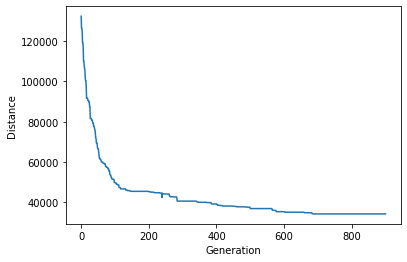

In [ ]:
start = time.time()

GAplot = GAsolution(cityList=cityList48, populationSize=120, numElite=20, numGenerations=900, mutationRate=0.001, mutationType="swap")

plt.savefig('./swap_mutation/results1/plot1.png', bbox_inches = 'tight')

print(str(time.time()-start) + "seconds to run")

Distance of First Route: 130216.3421663599
Distance of last computed Route: 40135.50376005174
Best achieved Route distance: 40135.50376005174
1949.8221340179443seconds to run
Distance of First Route: 131231.01248474367
Distance of last computed Route: 39365.15777579603
Best achieved Route distance: 39365.15777579603
2486.804869890213seconds to run
Distance of First Route: 128855.93007576128
Distance of last computed Route: 38557.61215578913
Best achieved Route distance: 38557.61215578913
3023.5916800498962seconds to run
Distance of First Route: 134642.23842373674
Distance of last computed Route: 40595.25590952986
Best achieved Route distance: 40595.25590952986
3561.771659851074seconds to run
Distance of First Route: 127643.47673643884
Distance of last computed Route: 42585.00097215776
Best achieved Route distance: 42585.00097215776
4098.329527616501seconds to run
Distance of First Route: 127062.83314133376
Distance of last computed Route: 42363.77186075286
Best achieved Route distance:

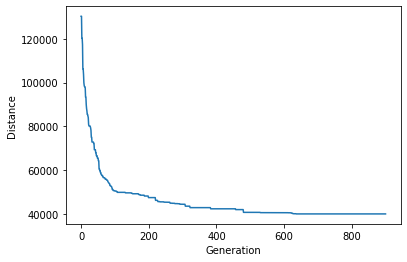

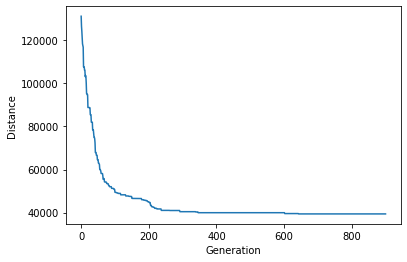

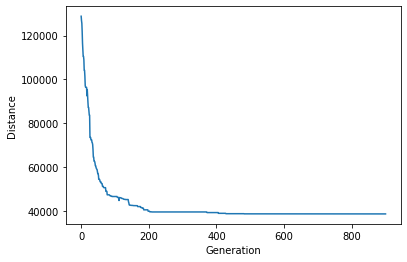

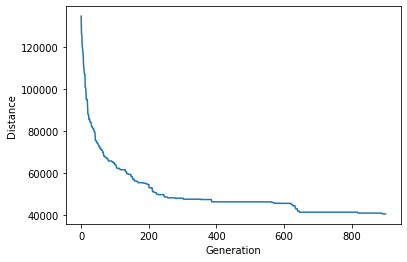

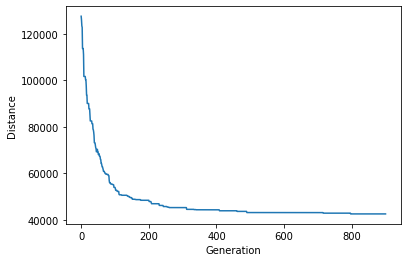

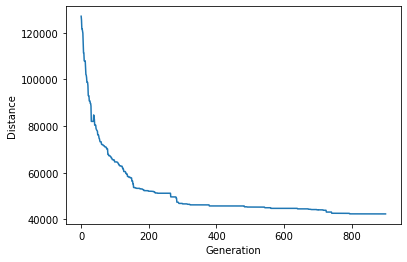

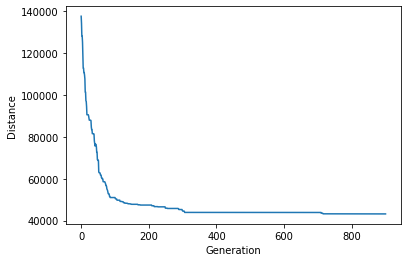

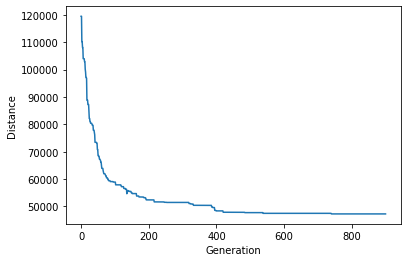

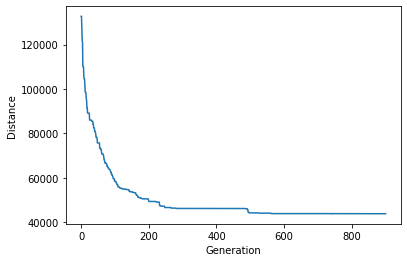

In [ ]:
for i in range(0,9):

  start = time.time()

  GAplot = GAsolution(cityList=cityList48, populationSize=120, numElite=20, numGenerations=900, mutationRate=0.001, mutationType="swap")
  plotname = './swap_mutation/results1/plot'+str(i+1)+'.png'
  plt.savefig(plotname, bbox_inches = 'tight')


  

  print(str(time.time()-start) + "seconds to run")

Distance of First Route: 123881.67651629924
Distance of last computed Route: 47343.05362979881
Best achieved Route distance: 42278.70172760725
14085.169826507568seconds to run
Distance of First Route: 126713.05004775805
Distance of last computed Route: 54983.36098298731
Best achieved Route distance: 44559.404428723254
14599.2140686512seconds to run
Distance of First Route: 130786.7609566989
Distance of last computed Route: 48447.525095073506
Best achieved Route distance: 42788.02096939251
15118.160792827606seconds to run
Distance of First Route: 134864.2019864172
Distance of last computed Route: 50060.02861908494
Best achieved Route distance: 45695.36457753275
15635.255424976349seconds to run
Distance of First Route: 137270.4783993524
Distance of last computed Route: 43964.47325798866
Best achieved Route distance: 40957.327820024795
16148.872190713882seconds to run
Distance of First Route: 128497.66738158098
Distance of last computed Route: 47869.129274170504
Best achieved Route distan

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()


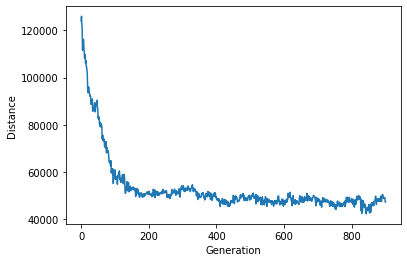

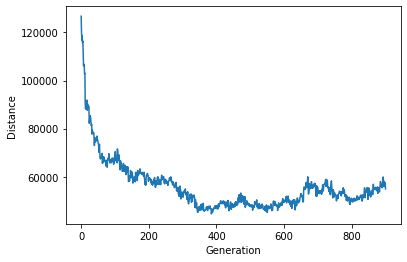

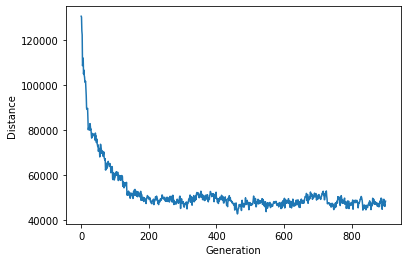

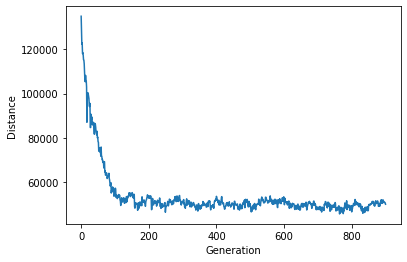

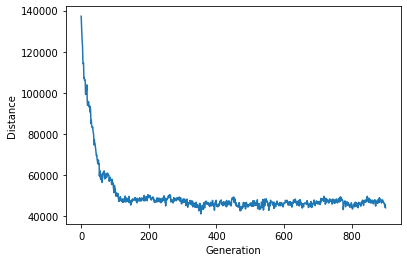

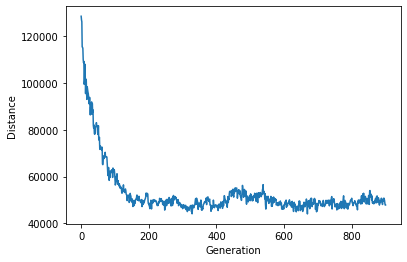

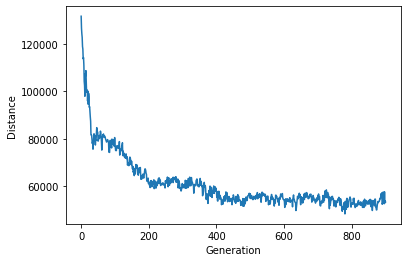

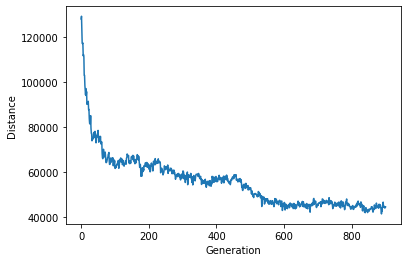

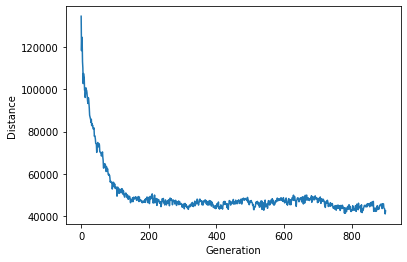

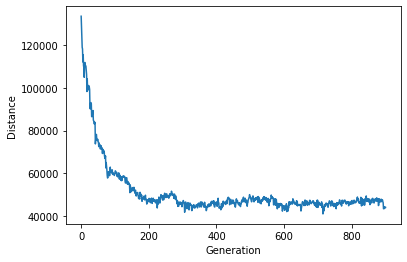

In [ ]:
for i in range(0,10):

  start = time.time()

  GAplot = GAsolution(cityList=cityList48, populationSize=120, numElite=20, numGenerations=900, mutationRate=0.001, mutationType="inversion")
  plotname = './inversion_mutation/results1/plot'+str(i+1)+'.png'
  plt.savefig(plotname, bbox_inches = 'tight')

  print(str(time.time()-start) + "seconds to run")

Distance of First Route: 129334.60509727472
Distance of last computed Route: 47281.04118485579
Best achieved Route distance: 41840.12029475117
514.8201615810394seconds to run
Distance of First Route: 134075.97651624423
Distance of last computed Route: 45578.681925801844
Best achieved Route distance: 40987.624617093126
517.8227255344391seconds to run
Distance of First Route: 131581.11119313282
Distance of last computed Route: 46190.643668910205
Best achieved Route distance: 41577.0739860256
515.193977355957seconds to run
Distance of First Route: 127356.10852577684
Distance of last computed Route: 52067.420253501965
Best achieved Route distance: 46725.242092745015
515.4561524391174seconds to run
Distance of First Route: 126285.36233291599
Distance of last computed Route: 47093.83683550214
Best achieved Route distance: 43467.80863282348
518.9817202091217seconds to run
Distance of First Route: 128285.73218992246
Distance of last computed Route: 58888.856487054756
Best achieved Route distan

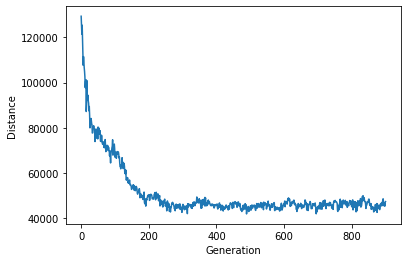

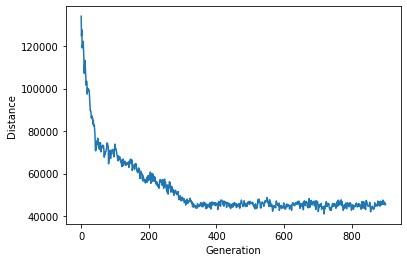

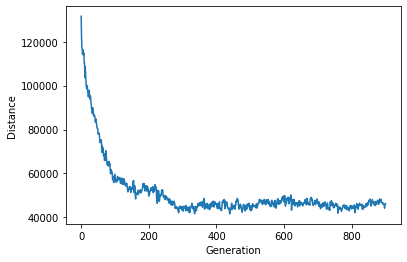

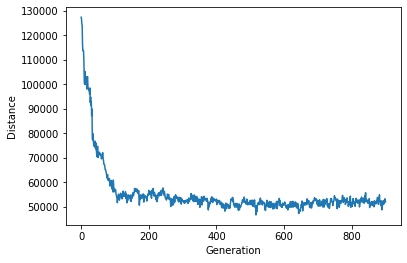

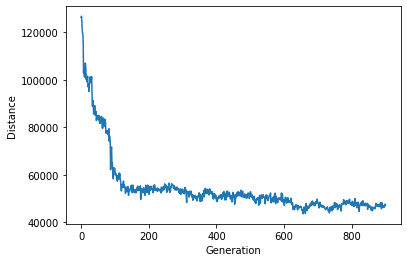

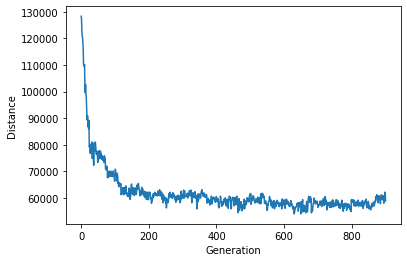

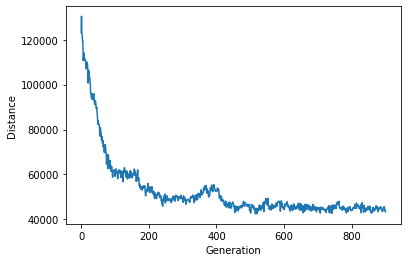

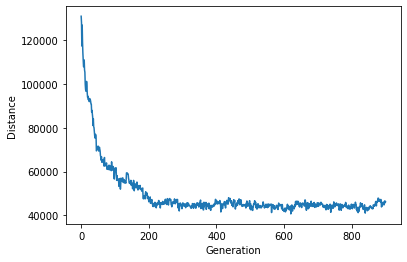

In [ ]:
for i in range(0,10):

  start = time.time()

  GAplot = GAsolution(cityList=cityList48, populationSize=120, numElite=20, numGenerations=900, mutationRate=0.001, mutationType="scramble")
  plotname = './scramble_mutation/results1/plot'+str(i+1)+'.png'
  plt.savefig(plotname, bbox_inches = 'tight')

  print(str(time.time()-start) + "seconds to run")

Distance of First Route: 125442.1329015482
Distance of last computed Route: 54508.70815882653
Best achieved Route distance: 53326.66637953576
534.263254404068seconds to run


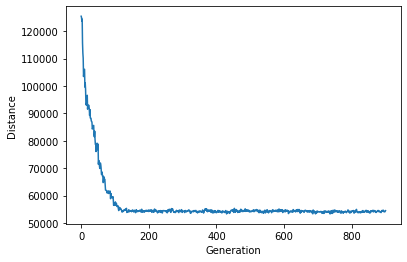

In [ ]:
start = time.time()

GAplot = GAsolution(cityList=cityList48, populationSize=120, numElite=20, numGenerations=900, mutationRate=0.001, mutationType="inversion")
plotname = './inversion_mutation/results1/plot12.png'
plt.savefig(plotname, bbox_inches = 'tight')

print(str(time.time()-start) + "seconds to run")


Distance of First Route: 121249.13692598569
Distance of last computed Route: 56739.5660400433
Best achieved Route distance: 56739.5660400433
535.6324572563171seconds to run


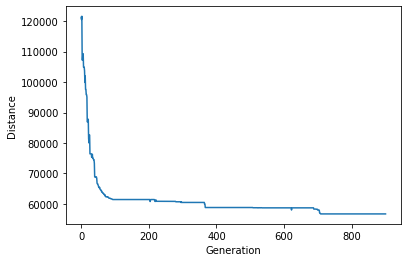

In [ ]:
start = time.time()

GAplot = GAsolution(cityList=cityList48, populationSize=120, numElite=20, numGenerations=900, mutationRate=0.001, mutationType="scramble")
plotname = '/scramble_mutation/results1/plot12.png'
plt.savefig(plotname, bbox_inches = 'tight')

print(str(time.time()-start) + "seconds to run")


Distance of First Route: 130597.82709512359
Distance of last computed Route: 45383.71669476265
Best achieved Route distance: 45383.71669476265

Best Route is : 

[(7762, 4595), (7732, 4723), (7555, 4819), (7611, 5184), (7280, 4899), (5989, 2873), (5468, 2606), (5185, 3258), (4483, 3369), (3245, 3305), (3484, 2829), (4307, 2322), (4612, 2035), (5530, 1424), (6101, 1110), (6107, 669), (7265, 1268), (7392, 2244), (7545, 2801), (7509, 3239), (7573, 3716), (7462, 3590), (7248, 3779), (6426, 3173), (6347, 2683), (5199, 2182), (4608, 1198), (4985, 140), (3177, 756), (401, 841), (1112, 2049), (1633, 2809), (10, 2676), (23, 2216), (2233, 10), (675, 1006), (1916, 1569), (3082, 1644), (3023, 1942), (4706, 2674), (5900, 3561), (7352, 4506), (7608, 4458), (7541, 3981), (6807, 2993), (6271, 2135), (6734, 1453), (6898, 1885)]
565.2996110916138seconds to run
Distance of First Route: 121829.46469635137
Distance of last computed Route: 44181.205183577345
Best achieved Route distance: 44181.205183577345


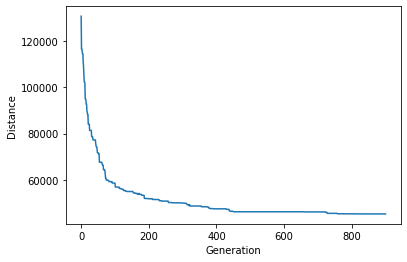

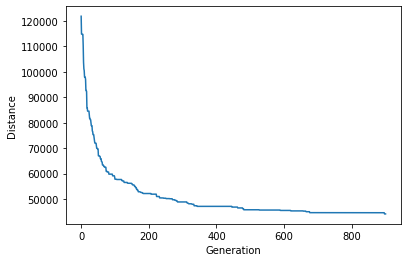

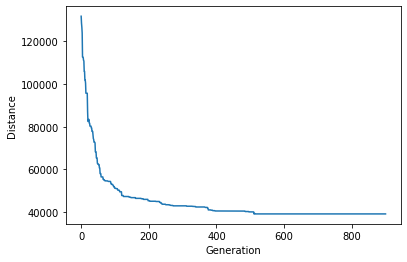

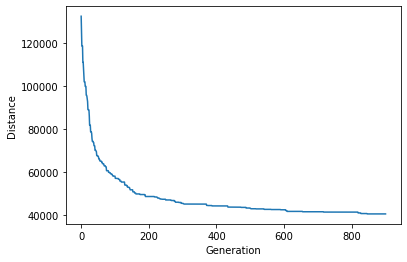

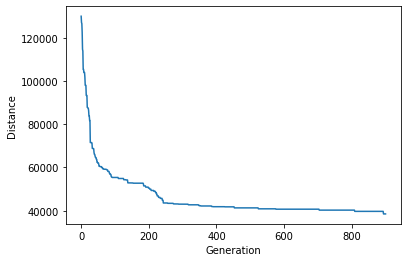

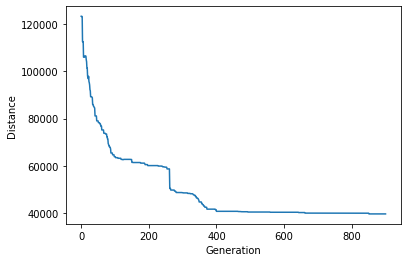

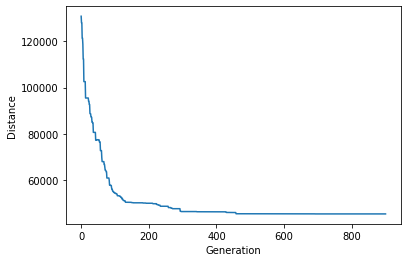

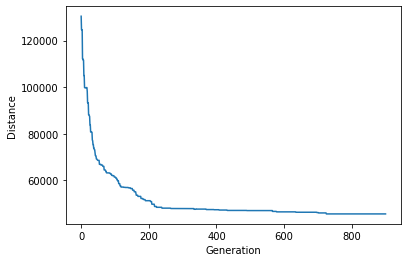

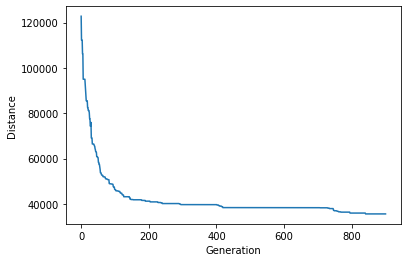

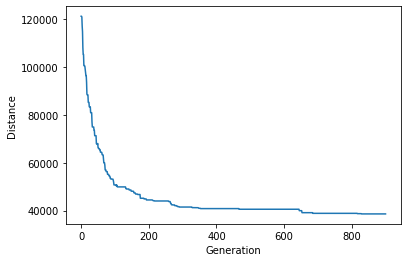

In [23]:
for i in range(0,10):

  start = time.time()

  GAplot = GAsolution(cityList=cityList48, populationSize=120, numElite=20, numGenerations=900, mutationRate=0.001, mutationType="swap")
  plotname = './swap_mutation/results2/plot'+str(i+1)+'.png'
  plt.savefig(plotname, bbox_inches = 'tight')


  

  print(str(time.time()-start) + "seconds to run")

Distance of First Route: 125660.50840252596
Distance of last computed Route: 48743.19108622941
Best achieved Route distance: 42415.227508949305

Best Route is : 

[(3484, 2829), (1633, 2809), (7611, 5184), (7352, 4506), (7732, 4723), (7608, 4458), (7762, 4595), (7248, 3779), (7509, 3239), (7541, 3981), (7462, 3590), (7573, 3716), (7545, 2801), (6347, 2683), (5989, 2873), (5900, 3561), (6426, 3173), (6807, 2993), (6271, 2135), (7392, 2244), (6898, 1885), (7265, 1268), (6734, 1453), (6101, 1110), (6107, 669), (4985, 140), (5530, 1424), (4608, 1198), (4706, 2674), (5185, 3258), (5199, 2182), (5468, 2606), (4612, 2035), (4307, 2322), (3245, 3305), (3023, 1942), (3082, 1644), (3177, 756), (2233, 10), (1916, 1569), (1112, 2049), (675, 1006), (401, 841), (23, 2216), (10, 2676), (7555, 4819), (7280, 4899), (4483, 3369)]
547.9010057449341seconds to run
Distance of First Route: 121573.93624361337
Distance of last computed Route: 47573.09048390012
Best achieved Route distance: 44439.036316639154


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


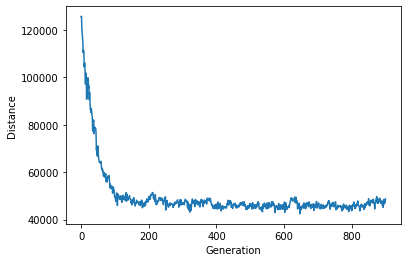

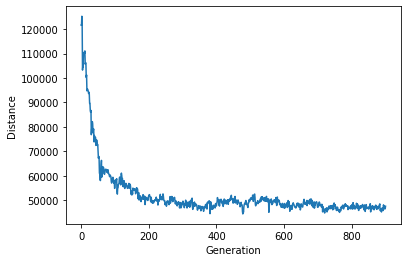

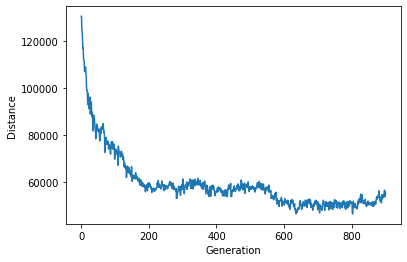

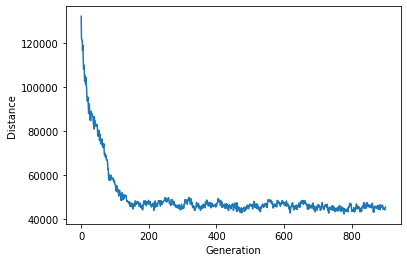

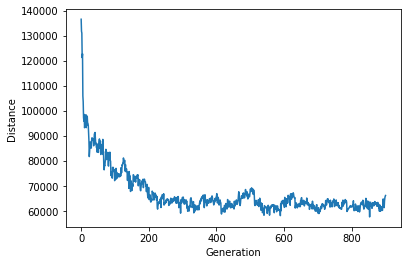

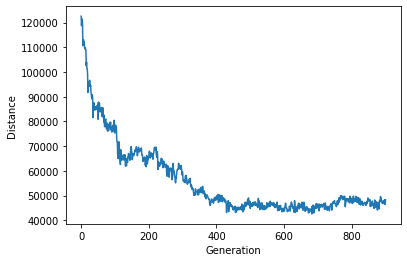

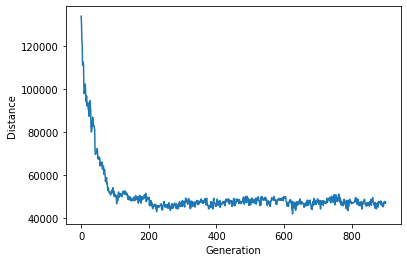

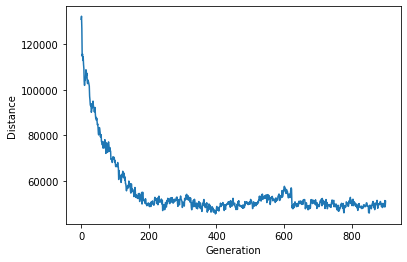

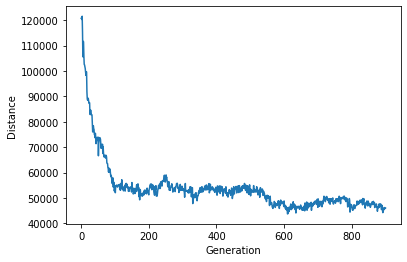

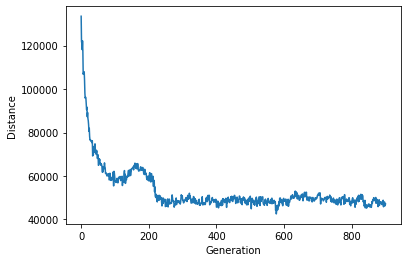

In [24]:
for i in range(0,10):

  start = time.time()

  GAplot = GAsolution(cityList=cityList48, populationSize=120, numElite=20, numGenerations=900, mutationRate=0.001, mutationType="inversion")
  plotname = './inversion_mutation/results2/plot'+str(i+1)+'.png'
  plt.savefig(plotname, bbox_inches = 'tight')


  

  print(str(time.time()-start) + "seconds to run")

Distance of First Route: 131320.167552125
Distance of last computed Route: 46682.40868810018
Best achieved Route distance: 42341.94955694996

Best Route is : 

[(23, 2216), (1112, 2049), (10, 2676), (4483, 3369), (401, 841), (675, 1006), (1916, 1569), (2233, 10), (3177, 756), (3082, 1644), (3023, 1942), (3484, 2829), (3245, 3305), (4307, 2322), (5199, 2182), (4608, 1198), (4985, 140), (6101, 1110), (5468, 2606), (5185, 3258), (5900, 3561), (7555, 4819), (7732, 4723), (7280, 4899), (7608, 4458), (7611, 5184), (7352, 4506), (7762, 4595), (7541, 3981), (7573, 3716), (7248, 3779), (7462, 3590), (7509, 3239), (7545, 2801), (6271, 2135), (6347, 2683), (5989, 2873), (6807, 2993), (6426, 3173), (7392, 2244), (6898, 1885), (6734, 1453), (7265, 1268), (6107, 669), (5530, 1424), (4612, 2035), (4706, 2674), (1633, 2809)]
545.1797852516174seconds to run


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Distance of First Route: 118149.50893328397
Distance of last computed Route: 57701.109060151015
Best achieved Route distance: 56075.38173303602

Best Route is : 

[(1916, 1569), (23, 2216), (1112, 2049), (10, 2676), (3484, 2829), (3245, 3305), (675, 1006), (401, 841), (2233, 10), (4985, 140), (4608, 1198), (7265, 1268), (6898, 1885), (7248, 3779), (7573, 3716), (7541, 3981), (7732, 4723), (7352, 4506), (7611, 5184), (7280, 4899), (7555, 4819), (7608, 4458), (5900, 3561), (7545, 2801), (7509, 3239), (7762, 4595), (6101, 1110), (6107, 669), (5530, 1424), (3177, 756), (3082, 1644), (3023, 1942), (1633, 2809), (4612, 2035), (4307, 2322), (5199, 2182), (5468, 2606), (4706, 2674), (4483, 3369), (5185, 3258), (6271, 2135), (5989, 2873), (6807, 2993), (6347, 2683), (6734, 1453), (6426, 3173), (7462, 3590), (7392, 2244)]
545.4959411621094seconds to run
Distance of First Route: 133129.56129814291
Distance of last computed Route: 45048.668461458685
Best achieved Route distance: 42297.591421036996

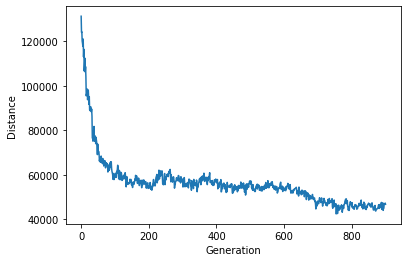

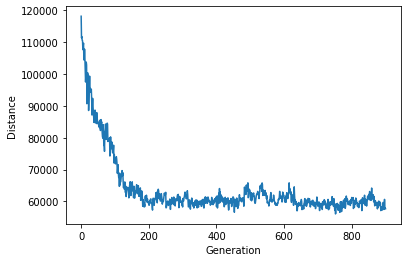

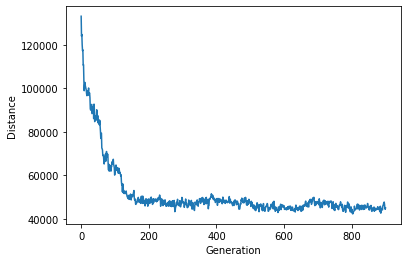

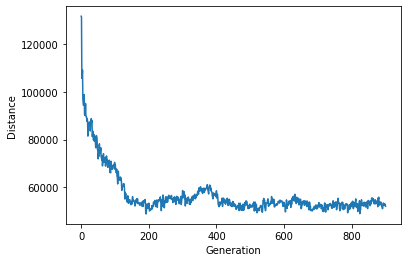

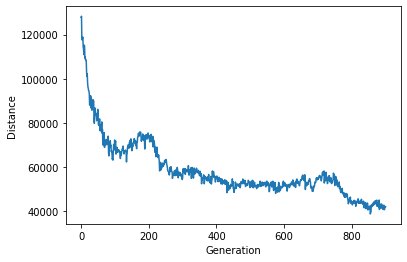

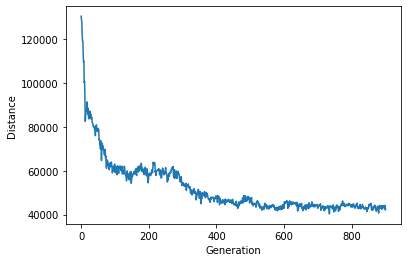

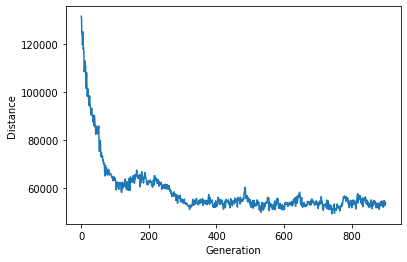

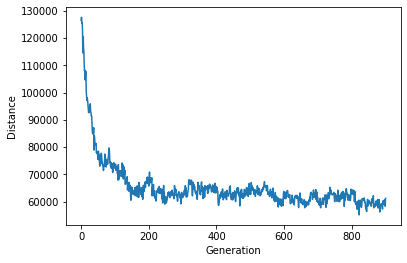

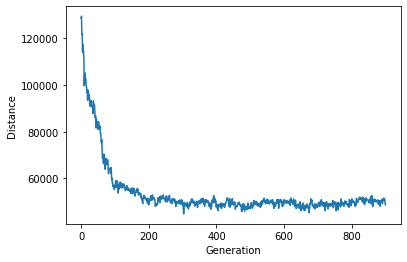

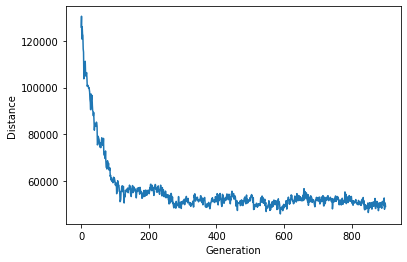

In [25]:
for i in range(0,10):

  start = time.time()

  GAplot = GAsolution(cityList=cityList48, populationSize=120, numElite=20, numGenerations=900, mutationRate=0.001, mutationType="scramble")
  plotname = './scramble_mutation/results2/plot'+str(i+1)+'.png'
  plt.savefig(plotname, bbox_inches = 'tight')


  

  print(str(time.time()-start) + "seconds to run")

# Observations : 

# First trial : 

Each mutation type (swap, inversion, scramble) were run for 10 runs, the logs (text files) and the plots were recorded. The best route was not recorded during this run.

Since inversion and scramble mutations saw higher variation during runs due to the mutation rate, the mutation rate was toned down from 0.001 to 0.0005 for 2 more runs each, and the plots for this was also recorded (plot11, plot12). Best mutation method seems to be 'swap mutation' at the given mutationRate. More number of generations might lead to a better minimum distance with inversion / scramble mutations.

The results for Trial 1 have been recorded in 'results1' directory.

# Second Trial : 

Each of the mutation types (swap, inversion, scramble) were run for another 10 runs to confirm the fact that swap mutation was indeed the best out of the three mutation types. The best routes were recorded for this run. 

The results for Trial 2 have been recorded in 'results2' directory. 

# Results : 

**Best achieved distance for trial 1 was** : **34333.36**, with swap mutation.  
**Best achieved distance for trial 2 was** : **35542.88**, with swap mutation.  

**The true optimal solution for the dataset is** : **33523**

The average runtime of each execution was about 560 seconds. 

All the associated files and plots are stored in the same zipfile as this notebook, 'RiviAssignment'. 